#Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Installing Dependencies and Importing Modules

In [2]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pydot
!pip install pydotplus
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from keras.utils import plot_model
from torchsummary import summary
from PIL import Image


import warnings
warnings.filterwarnings("ignore")

plt.ion()   

In [5]:
image_size = 64
stats = (0.5, 0.5, 0.5),(0.5, 0.5, 0.5)

In [6]:
def denorm(image_tensors):
    
    return image_tensors * stats[0][1] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=64):
    for images,_ in dl:
        show_images(images)
        break

#Load Dataset

In [8]:
datasheet = pd.read_csv('/content/drive/MyDrive/deepLearningProject/DL-ClassProject-Data_ver1.csv')
datasheet.head()

,File Name,Face Shape,Type,Color of Lip,Forehead,Cheeks with Dimple,Shape,Eye Size,In Eye,Eye Color,...,Eyebrows,Jaw Line,Skin Color,Hair Color,Hair Style,Beard Mustache Style,Nose,Age (Rough estimate as appearing),Gender,Identification mark if any (describe)
0,S1.jpeg,Diamond,Heavy lower lips,Pink,Fuzzi-Mount,Yes,pointed ear,Big Eye,No visible defect,Brown,...,High Seperated,Sharp,Fair,Black,Long hair girl,Shaven,Straight,32,Female,No
1,S50.jpeg,Rectangle,Heavy lower lips,Black,Broad,No,narrow ear,Medium Eye,No visible defect,Black,...,Seperated,Flat,Dark,Black,Half Bald,Shaven,Raised,18,Male,na
2,S53.jpg,Oblong,Thin lips,Pink,Straight,No,Broad lobe,Medium Eye,No visible defect,Gray,...,Seperated,Flat,White,Black and white mixed,Medium length male,Shaven,Lowered,50,Male,Non
3,S54.jpeg,Diamond,Heavy upper lips,Pink,Broad,No,pointed ear,Medium Eye,No visible defect,Gray,...,Seperated,Sharp,White,Golden,Long hair girl,Shaven,Straight,32,Female,NaN
4,S52.jpeg,Diamond,Heavy lower lips,Pink,Straight,Yes,Broad lobe,Big Eye,No visible defect,Black,...,High Seperated,Sharp,Fair,Black,Long hair girl,Shaven,Straight,31,Female,No


In [9]:
train_df = pd.DataFrame(datasheet)

In [10]:
train_df

,File Name,Face Shape,Type,Color of Lip,Forehead,Cheeks with Dimple,Shape,Eye Size,In Eye,Eye Color,...,Eyebrows,Jaw Line,Skin Color,Hair Color,Hair Style,Beard Mustache Style,Nose,Age (Rough estimate as appearing),Gender,Identification mark if any (describe)
0,S1.jpeg,Diamond,Heavy lower lips,Pink,Fuzzi-Mount,Yes,pointed ear,Big Eye,No visible defect,Brown,...,High Seperated,Sharp,Fair,Black,Long hair girl,Shaven,Straight,32,Female,No
1,S50.jpeg,Rectangle,Heavy lower lips,Black,Broad,No,narrow ear,Medium Eye,No visible defect,Black,...,Seperated,Flat,Dark,Black,Half Bald,Shaven,Raised,18,Male,na
2,S53.jpg,Oblong,Thin lips,Pink,Straight,No,Broad lobe,Medium Eye,No visible defect,Gray,...,Seperated,Flat,White,Black and white mixed,Medium length male,Shaven,Lowered,50,Male,Non
3,S54.jpeg,Diamond,Heavy upper lips,Pink,Broad,No,pointed ear,Medium Eye,No visible defect,Gray,...,Seperated,Sharp,White,Golden,Long hair girl,Shaven,Straight,32,Female,NaN
4,S52.jpeg,Diamond,Heavy lower lips,Pink,Straight,Yes,Broad lobe,Big Eye,No visible defect,Black,...,High Seperated,Sharp,Fair,Black,Long hair girl,Shaven,Straight,31,Female,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,S986.jpeg,Oval,Heavy lower lips,Red,Narrow,No,narrow ear,Medium Eye,No visible defect,Brown,...,Seperated,Round,Fair,Black,Medium length male,Stubble (short),Straight,28,Male,no
974,S987.jpg,Rectangle,Thin lips,Pink,Narrow,No,pointed ear,Medium Eye,No visible defect,Hazel,...,Seperated,Sharp,White,Black,Medium length male,Full beard,Wavy,29,Male,none
975,S988.jpg,Diamond,Wide Lips,Pink,Narrow,No,Broad lobe,Medium Eye,No visible defect,Brown,...,Seperated,Sharp,Brown,Brown,Long hair girl,Shaven,Concave,26,Female,none
976,S989.jpeg,Oval,Heart shaped lips,Pink,Straight,No,narrow ear,Medium Eye,No visible defect,Gray,...,Joined,Sharp,White,Black,Small hair,Shaven,Convex,24,Male,No identification mark


In [11]:
len(train_df)

978

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_encoded = le.fit_transform(train_df['Color of Lip'])
train_df['label_encoded'] = label_encoded
label_names = le.classes_
label_names

array(['Black', 'Pink', 'Red', 'Skin'], dtype=object)

In [13]:
train_df.head()

,File Name,Face Shape,Type,Color of Lip,Forehead,Cheeks with Dimple,Shape,Eye Size,In Eye,Eye Color,...,Jaw Line,Skin Color,Hair Color,Hair Style,Beard Mustache Style,Nose,Age (Rough estimate as appearing),Gender,Identification mark if any (describe),label_encoded
0,S1.jpeg,Diamond,Heavy lower lips,Pink,Fuzzi-Mount,Yes,pointed ear,Big Eye,No visible defect,Brown,...,Sharp,Fair,Black,Long hair girl,Shaven,Straight,32,Female,No,1
1,S50.jpeg,Rectangle,Heavy lower lips,Black,Broad,No,narrow ear,Medium Eye,No visible defect,Black,...,Flat,Dark,Black,Half Bald,Shaven,Raised,18,Male,na,0
2,S53.jpg,Oblong,Thin lips,Pink,Straight,No,Broad lobe,Medium Eye,No visible defect,Gray,...,Flat,White,Black and white mixed,Medium length male,Shaven,Lowered,50,Male,Non,1
3,S54.jpeg,Diamond,Heavy upper lips,Pink,Broad,No,pointed ear,Medium Eye,No visible defect,Gray,...,Sharp,White,Golden,Long hair girl,Shaven,Straight,32,Female,NaN,1
4,S52.jpeg,Diamond,Heavy lower lips,Pink,Straight,Yes,Broad lobe,Big Eye,No visible defect,Black,...,Sharp,Fair,Black,Long hair girl,Shaven,Straight,31,Female,No,1


In [14]:
img_transforms = transforms.Compose([transforms.Resize((600, 600)),
                                     transforms.CenterCrop(400),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

In [15]:
batch_size = 128
latent_size = 128

In [16]:
def get_default_device():
    
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [17]:
def to_device(data, device):

    if isinstance(data, (list, tuple)):
        return [to_device(each, device) for each in data]
    else:
        return data.to(device, non_blocking = True)

In [18]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
      
  def __iter__(self):
    for b in self.dl:
        yield to_device(b, self.device)
          
  def __len__(self):
    return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

#Creating Custom Dataset Class

In [20]:
class ImgDataset(Dataset):
  def __init__(self, data_frame, images_folder, transform = img_transforms):
    self.df = data_frame
    self.images_folder = images_folder
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    if torch.is_tensor(index):
      index = index.tolist()

    img_name = os.path.join(self.images_folder, self.df.iloc[index, 0])
    image = Image.open(img_name)
    label = self.df.iloc[index, -1]
    
    if self.transform:
        image = self.transform(image)

    return (image, label)

In [21]:
train_dataset = ImgDataset(train_df, "/content/drive/MyDrive/deepLearningProject/raw_imgs/raw_images")

image, ColorOfLip = train_dataset[2]
print(ColorOfLip)

1


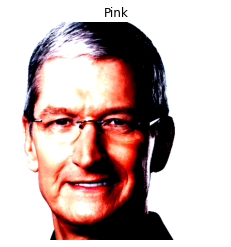

In [22]:
temp_img, temp_lab = train_dataset[2]
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))
plt.title(label_names[temp_lab])
plt.axis('off')
plt.show()

In [23]:
FOLDER_DIR = '/content/drive/MyDrive/deepLearningProject/raw_imgs/'

In [24]:
dataset = ImageFolder(FOLDER_DIR, transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(*stats)]))

#Loading Custom Dataset

In [25]:
dataloader = DataLoader(dataset, batch_size, shuffle=True, pin_memory = True, num_workers = 3)

In [26]:
dataloader = DeviceDataLoader(dataloader, device)

In [27]:
dataset

Dataset ImageFolder
    Number of datapoints: 977
    Root location: /content/drive/MyDrive/deepLearningProject/raw_imgs/
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [28]:
DATA_DIR = '/content/drive/MyDrive/deepLearningProject/raw_imgs/raw_images/'
photos_in_folder = os.listdir(DATA_DIR)

In [29]:
cols = [0]
my_df = train_df[train_df.columns[cols]]
my_df.head()

,File Name
0,S1.jpeg
1,S50.jpeg
2,S53.jpg
3,S54.jpeg
4,S52.jpeg


#Discriminator Network

In [30]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),
    
    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),
    
    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    
    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),
    
    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    
    nn.Flatten(),
    nn.Sigmoid()
    
)

In [31]:
discriminator = to_device(discriminator, device)
summary(discriminator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

#Generator Network

In [32]:
latent_size = 128

In [33]:
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()
    
)

torch.Size([128, 3, 64, 64])


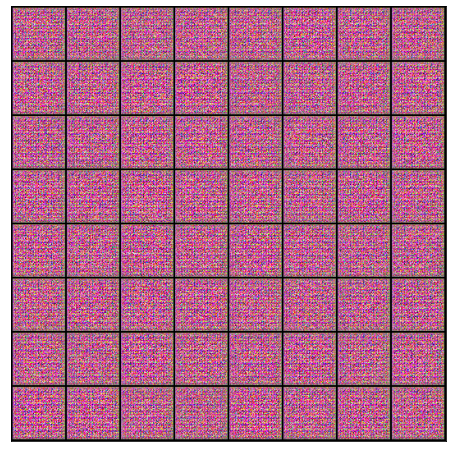

In [34]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)

print(fake_images.shape)
show_images(fake_images)

In [35]:
generator = to_device(generator, device)
summary(generator, (latent_size, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

#Training Functions

In [36]:
def train_discriminator(real_images, opt_d):
    
    opt_d.zero_grad()
    
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

In [37]:
def train_generator(opt_g):
    
    opt_g.zero_grad()
    
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    fake_preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device = device)
    loss = F.binary_cross_entropy(fake_preds, targets)
    
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [38]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [39]:
def save_samples(index, latent_tensors, show = True):
    
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [40]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


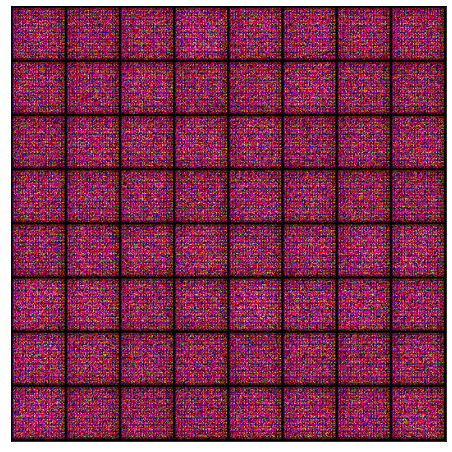

In [41]:
save_samples(0, fixed_latent)

In [42]:
def mainTraining(epochs, lr, start_idx = 1):
    
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999)) 
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999)) 
    
    for epoch in range(epochs):
        
        for real_images,_ in tqdm(dataloader):
            
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            loss_g = train_generator(opt_g)
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        save_samples(epoch+start_idx, fixed_latent, show=False)
        
    return losses_g, losses_d, real_scores, fake_scores

In [43]:
lr = 0.0002
epochs = 30

In [44]:
history = mainTraining(epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/30], loss_g: 6.7984, loss_d: 0.5394, real_score: 0.8532, fake_score: 0.2485
Saving generated-images-0001.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/30], loss_g: 11.2786, loss_d: 0.4636, real_score: 0.9488, fake_score: 0.3254
Saving generated-images-0002.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/30], loss_g: 12.1228, loss_d: 0.1258, real_score: 0.9132, fake_score: 0.0003
Saving generated-images-0003.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/30], loss_g: 11.5218, loss_d: 0.9792, real_score: 0.9296, fake_score: 0.5616
Saving generated-images-0004.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/30], loss_g: 12.8872, loss_d: 0.3529, real_score: 0.8126, fake_score: 0.0000
Saving generated-images-0005.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/30], loss_g: 9.5623, loss_d: 0.1420, real_score: 0.8960, fake_score: 0.0002
Saving generated-images-0006.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/30], loss_g: 12.5045, loss_d: 1.4171, real_score: 0.9443, fake_score: 0.7026
Saving generated-images-0007.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/30], loss_g: 10.2253, loss_d: 0.1855, real_score: 0.8578, fake_score: 0.0004
Saving generated-images-0008.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/30], loss_g: 5.0370, loss_d: 0.0768, real_score: 0.9446, fake_score: 0.0142
Saving generated-images-0009.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/30], loss_g: 4.4133, loss_d: 0.2201, real_score: 0.8775, fake_score: 0.0537
Saving generated-images-0010.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11/30], loss_g: 6.3088, loss_d: 0.1820, real_score: 0.8872, fake_score: 0.0425
Saving generated-images-0011.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12/30], loss_g: 5.8841, loss_d: 0.2139, real_score: 0.9151, fake_score: 0.1089
Saving generated-images-0012.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13/30], loss_g: 6.1194, loss_d: 0.1320, real_score: 0.9223, fake_score: 0.0413
Saving generated-images-0013.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14/30], loss_g: 5.9912, loss_d: 0.1468, real_score: 0.9217, fake_score: 0.0568
Saving generated-images-0014.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15/30], loss_g: 5.5992, loss_d: 0.1588, real_score: 0.9276, fake_score: 0.0747
Saving generated-images-0015.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16/30], loss_g: 5.4663, loss_d: 0.1366, real_score: 0.9149, fake_score: 0.0412
Saving generated-images-0016.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17/30], loss_g: 5.4057, loss_d: 0.6119, real_score: 0.8641, fake_score: 0.3073
Saving generated-images-0017.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18/30], loss_g: 4.9203, loss_d: 3.0859, real_score: 0.3408, fake_score: 0.0284
Saving generated-images-0018.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19/30], loss_g: 2.7677, loss_d: 0.6571, real_score: 0.6733, fake_score: 0.1362
Saving generated-images-0019.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/30], loss_g: 3.3276, loss_d: 0.4554, real_score: 0.7674, fake_score: 0.1378
Saving generated-images-0020.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21/30], loss_g: 2.2656, loss_d: 0.3910, real_score: 0.7748, fake_score: 0.0943
Saving generated-images-0021.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22/30], loss_g: 3.9076, loss_d: 0.4297, real_score: 0.8717, fake_score: 0.2381
Saving generated-images-0022.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23/30], loss_g: 4.9447, loss_d: 0.7786, real_score: 0.9446, fake_score: 0.4494
Saving generated-images-0023.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24/30], loss_g: 3.3396, loss_d: 0.2710, real_score: 0.8614, fake_score: 0.1010
Saving generated-images-0024.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25/30], loss_g: 4.7959, loss_d: 0.4458, real_score: 0.8839, fake_score: 0.2480
Saving generated-images-0025.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26/30], loss_g: 3.8461, loss_d: 0.2544, real_score: 0.8633, fake_score: 0.0758
Saving generated-images-0026.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27/30], loss_g: 1.8479, loss_d: 0.4186, real_score: 0.8265, fake_score: 0.1433
Saving generated-images-0027.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28/30], loss_g: 2.0542, loss_d: 0.6040, real_score: 0.6722, fake_score: 0.1080
Saving generated-images-0028.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29/30], loss_g: 2.9428, loss_d: 0.5603, real_score: 0.7607, fake_score: 0.1791
Saving generated-images-0029.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30/30], loss_g: 4.1144, loss_d: 0.3439, real_score: 0.8580, fake_score: 0.1521
Saving generated-images-0030.png


In [45]:
losses_g, losses_d, real_scores, fake_scores = history

In [46]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [47]:
from IPython.display import Image

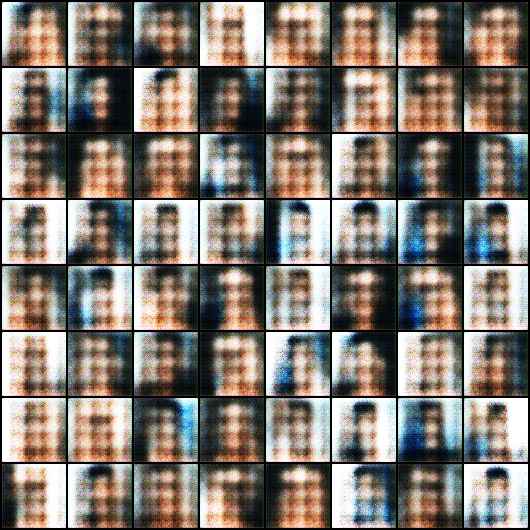

In [48]:
Image('/content/generated/generated-images-0030.png')

#Plotting Losses



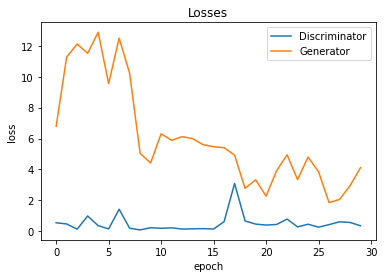

In [49]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

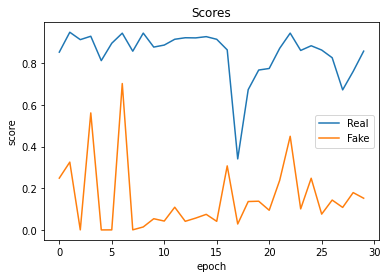

In [50]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');